In [143]:
import numpy as np
from scipy.linalg import svd
from omp import orthogonal_matching_pursuit_cholensky, orthogonal_matching_pursuit
import cv2
from utils import generate_data, extract_blocks
import random
from sklearn.feature_extraction.image import extract_patches_2d, reconstruct_from_patches_2d
from tqdm import tqdm
import scipy
import matplotlib.pyplot as plt
from PIL import Image
from sklearn.linear_model import OrthogonalMatchingPursuit

In [144]:
def dct2(a):
    return scipy.fftpack.dct(scipy.fftpack.dct( a, axis=0, norm='ortho' ), axis=1, norm='ortho' )

def idct2(a):
    return scipy.fftpack.idct( scipy.fftpack.idct( a, axis=0 , norm='ortho'), axis=1 , norm='ortho')

def learn_overcomplete_dictionary(image, block_size=(8, 8), num_atoms=128):
    # Extract blocks from image
    blocks = extract_blocks(image, block_size)
    
    # Initialize D_overcomplete matrix
    D_overcomplete = np.zeros((block_size[0] * block_size[1], num_atoms))
    
    # Iterate over blocks to fill D_overcomplete with DCT atoms
    for i in range(num_atoms):
        # Choose a random block index
        random_index = np.random.randint(len(blocks))
        block = blocks[random_index]
        # Compute DCT of the block
        # dct_block = dct2(block.reshape(block_size))
        
        # # Reshape and store the DCT coefficients as a column in D_overcomplete
        # D_overcomplete[:, i] = dct_block.flatten()
        D_overcomplete[:, i] = block.flatten()

    return D_overcomplete

im = Image.open("Figures/noisy_image0_noise_lvl5.jpg")
# im = im.resize((256, 256))
im_gray = np.array(im.convert('L'))

# start with n = 64 (8x8 patches) and K = 6000 (atoms in the dictionary)


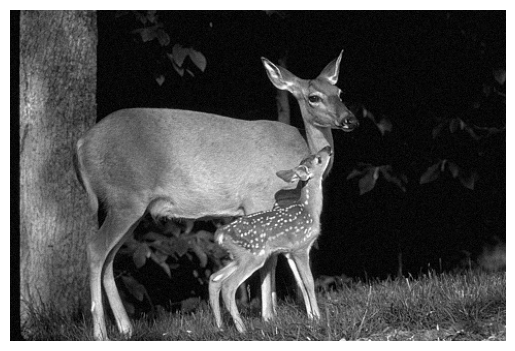

In [145]:
plt.imshow(im_gray, cmap='gray')  # cmap='gray' for grayscale image
plt.axis('off')  # Turn off axis
plt.show()

In [146]:
# training data y
from utils import generate_data

# training patches
sparsity_level = 8
K = 4000
block_size = (8,8) # patch size
training_data = generate_data(im_gray, K, block_size) 
dc_offset = np.mean(training_data)
# training_data -= dc_offset
training_data.shape

(4000, 64)

In [147]:
# sparsity:
T0 = 10
# sparse coding stage
# use any pursuit algorithm to compute represntation vectors xi for each example y1
from sklearn.linear_model import OrthogonalMatchingPursuit

# initialize D
D = learn_overcomplete_dictionary(im_gray,  block_size=(8, 8), num_atoms=128)

training_data.shape

(4000, 64)

In [148]:
def ksvd(Y, sparsity, initial_D,
    maxiter=10, etol=1e-10):
    """
                
        Data:       rows hold training data for dictionary fitting
        sparsity:   max sparsity of signals. Reduces to K-means
                    when sparsity=1
        initial_D:  if given, an initial dictionary. Otherwise, random
                    rows of data are chosen for initial dictionary
        maxiter:    maximum number of iterations
        err_thresh: stopping criteria; minimum residual
       
        
        Returns:
            D:               learned dictionary
            X:               sparse coding of input data
            error_norms:     array of training errors for each iteration
        Task: find best dictionary D to represent Data Y;
              minimize squared norm of Y - DX, constraining
              X to sparse codings.
    """

    D = initial_D
    D = initial_D / np.linalg.norm(D, axis=0)

    # repeat until convergence or stopping criteria    
    iterator = tqdm(range(1,maxiter+1))
    for iteration in iterator:
        # sparse coding stage: estimate columns of X
        omp = OrthogonalMatchingPursuit(n_nonzero_coefs=sparsity)
        # Fit the model and obtain the sparse code X
        print(f"{D.shape=}; {Y.shape=}")
        X = omp.fit(D, Y).coef_.T
        print(f"{X.shape=}")
        # print(f"{X.shape=}; {D.shape=}; {Y.shape=}")
        # codebook update stage
        for j in range(D.shape[1]):
            # index set of nonzero components
            index_set = np.nonzero(X[j,:])[0]
            if len(index_set) == 0:
                # for now, replace with some white noise
                D[:,j] = np.random.randn(*D[:,j].shape)
                D[:,j] = D[:,j] / np.linalg.norm(D[:,j])
                continue
            
            # error matrix E
            E_idx = np.delete(range(D.shape[1]), j, 0)
           
            E = Y - np.dot(D[:,E_idx], X[E_idx,:])
            U,S,VT = np.linalg.svd(E[:,index_set])
            # update jth column of D
            D[:,j] = U[:,0]
            
            # update sparse elements in jth row of X    
            X[j,:] = np.array([
                S[0]*VT[ 0,np.argwhere(index_set==n)[0][0] ]
                if n in index_set else 0
                for n in range(X.shape[1])])
            
        # stopping condition: check error        
        err = np.linalg.norm(Y-D.dot(X),'fro')

        if err < etol:
            break
        
    return D,X

In [149]:
D = learn_overcomplete_dictionary(im_gray,  block_size=(8, 8), num_atoms=128) # best (8,8), num_atoms=256
D_learned,X = ksvd(training_data.T, initial_D=D, sparsity=16) # best: sparsity=8

  0%|          | 0/10 [00:00<?, ?it/s]

D.shape=(64, 128); Y.shape=(64, 4000)


/home/mihai/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_omp.py:435: RuntimeWarning: Orthogonal matching pursuit ended prematurely due to linear dependence in the dictionary. The requested precision might not have been met.
  out = _cholesky_omp(


X.shape=(128, 4000)


 10%|█         | 1/10 [00:12<01:50, 12.33s/it]

D.shape=(64, 128); Y.shape=(64, 4000)
X.shape=(128, 4000)


 20%|██        | 2/10 [00:26<01:46, 13.30s/it]

D.shape=(64, 128); Y.shape=(64, 4000)
X.shape=(128, 4000)


 30%|███       | 3/10 [00:38<01:28, 12.61s/it]

D.shape=(64, 128); Y.shape=(64, 4000)
X.shape=(128, 4000)


 40%|████      | 4/10 [00:48<01:11, 11.86s/it]

D.shape=(64, 128); Y.shape=(64, 4000)
X.shape=(128, 4000)


 50%|█████     | 5/10 [00:59<00:57, 11.54s/it]

D.shape=(64, 128); Y.shape=(64, 4000)
X.shape=(128, 4000)


 60%|██████    | 6/10 [01:11<00:45, 11.45s/it]

D.shape=(64, 128); Y.shape=(64, 4000)
X.shape=(128, 4000)


 70%|███████   | 7/10 [01:21<00:33, 11.28s/it]

D.shape=(64, 128); Y.shape=(64, 4000)
X.shape=(128, 4000)


 80%|████████  | 8/10 [01:33<00:22, 11.33s/it]

D.shape=(64, 128); Y.shape=(64, 4000)
X.shape=(128, 4000)


 90%|█████████ | 9/10 [01:45<00:11, 11.58s/it]

D.shape=(64, 128); Y.shape=(64, 4000)
X.shape=(128, 4000)


100%|██████████| 10/10 [01:57<00:00, 11.74s/it]


In [150]:
print("Extracting reference patches...")
patch_size = (8, 8)
data = extract_patches_2d(im_gray, patch_size)
data = data.astype(np.float64)
data = data.reshape(data.shape[0], -1)
data -= np.mean(data, axis=0)
data /= np.std(data, axis=0)

Extracting reference patches...


In [151]:
denoised_patches = []

for i, reference_patch in enumerate(data):
    if i % 1000 == 0:
        print(f"Processing reference patch {i + 1}/{len(data)}...")
    
    # Apply the OMP algorithm to obtain the sparse representation
   
    omp = OrthogonalMatchingPursuit(n_nonzero_coefs=4)
    # print(f"{D_overcomplete.shape=}; {reference_patch.shape=}")
    omp.fit(D_learned, reference_patch)
    gamma = omp.coef_

    # Reconstruct the denoised patch using the sparse representation and the overcomplete dictionary
    denoised_patch = D_learned @ gamma.flatten()
    
    # Add the intercept (mean) to the denoised patch
    denoised_patch += np.mean(reference_patch)
    
    # Append the denoised patch to the list of denoised patches
    denoised_patches.append(denoised_patch.reshape(patch_size))

    

Processing reference patch 1/148836...
Processing reference patch 1001/148836...
Processing reference patch 2001/148836...
Processing reference patch 3001/148836...
Processing reference patch 4001/148836...
Processing reference patch 5001/148836...
Processing reference patch 6001/148836...
Processing reference patch 7001/148836...
Processing reference patch 8001/148836...
Processing reference patch 9001/148836...
Processing reference patch 10001/148836...
Processing reference patch 11001/148836...
Processing reference patch 12001/148836...
Processing reference patch 13001/148836...
Processing reference patch 14001/148836...
Processing reference patch 15001/148836...
Processing reference patch 16001/148836...
Processing reference patch 17001/148836...
Processing reference patch 18001/148836...
Processing reference patch 19001/148836...
Processing reference patch 20001/148836...
Processing reference patch 21001/148836...
Processing reference patch 22001/148836...
Processing reference pat

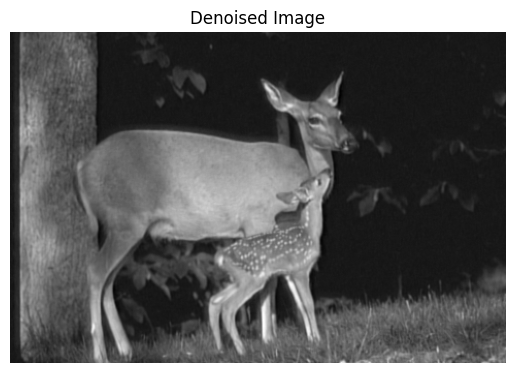

In [152]:
# data_mean = np.mean(data, axis=0)
# data_std = np.std(data, axis=0)
denoised_patches = np.array(denoised_patches) # * data_std + data_mean
# Assemble the denoised patches into the final denoised image
# data = extract_patches_2d(im_gray, patch_size=(8,8))
# denoised_image = reconstruct_from_patches_2d(denoised_patches * np.std(data, axis=0), im_gray.shape)
denoised_image = reconstruct_from_patches_2d(denoised_patches, im_gray.shape)
# Display the denoised image
plt.imshow(denoised_image, cmap='gray')
plt.title('Denoised Image')
plt.axis('off')
plt.show()

In [153]:
def normalize_image(image):
    """
    Normalize an image array to have values between 0 and 1.

    Parameters:
        image (numpy.ndarray): Input image array.

    Returns:
        numpy.ndarray: Normalized image array.
    """
    # Normalize the values between 0 and 1
    normalized_img = (image - image.min()) / (image.max() - image.min()) * 255
    
    return normalized_img

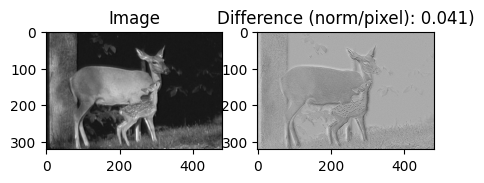

In [154]:
def show_with_diff(image, reference):
    """Helper function to display denoising"""
    plt.figure(figsize=(5, 3.3))
    plt.subplot(1, 2, 1)
    plt.title("Image")
    plt.imshow(image,cmap='gray')
    plt.subplot(1, 2, 2)
    difference = image-reference
    norm = np.sqrt(np.sum(difference**2))/image.shape[0] / image.shape[1]
    plt.title(f"Difference (norm/pixel): {np.round(norm,3)})")
    plt.imshow(difference,cmap='gray')
    # plt.suptitle(title, size=16)
    
denoised_image = normalize_image(denoised_image)
im_gray = normalize_image(im_gray)
show_with_diff(denoised_image, im_gray)

In [158]:
denoised_patches = []
from omp import orthogonal_matching_pursuit_cholensky, unsparse
for i, reference_patch in enumerate(data):
    if i % 1000 == 0:
        print(f"Processing reference patch {i + 1}/{len(data)}...")
    
    # Apply the OMP algorithm to obtain the sparse representation
   
    # omp = OrthogonalMatchingPursuit(n_nonzero_coefs=2)
    # print(f"{D_overcomplete.shape=}; {reference_patch.shape=}")
    # omp.fit(D_learned, reference_patch)
    # gamma = omp.coef_
    x, idx = orthogonal_matching_pursuit_cholensky(D_learned, reference_patch, K=4)
    gamma = unsparse(x, idx, D_learned.shape[1])
    # Reconstruct the denoised patch using the sparse representation and the overcomplete dictionary
    denoised_patch = D_learned @ gamma.flatten()
    
    # Add the intercept (mean) to the denoised patch
    denoised_patch += np.mean(reference_patch)
    
    # Append the denoised patch to the list of denoised patches
    denoised_patches.append(denoised_patch.reshape(patch_size))

Processing reference patch 1/148836...
Processing reference patch 1001/148836...
Processing reference patch 2001/148836...
Processing reference patch 3001/148836...
Processing reference patch 4001/148836...
Processing reference patch 5001/148836...
Processing reference patch 6001/148836...
Processing reference patch 7001/148836...
Processing reference patch 8001/148836...
Processing reference patch 9001/148836...
Processing reference patch 10001/148836...
Processing reference patch 11001/148836...
Processing reference patch 12001/148836...
Processing reference patch 13001/148836...
Processing reference patch 14001/148836...
Processing reference patch 15001/148836...
Processing reference patch 16001/148836...
Processing reference patch 17001/148836...
Processing reference patch 18001/148836...
Processing reference patch 19001/148836...
Processing reference patch 20001/148836...
Processing reference patch 21001/148836...
Processing reference patch 22001/148836...
Processing reference pat

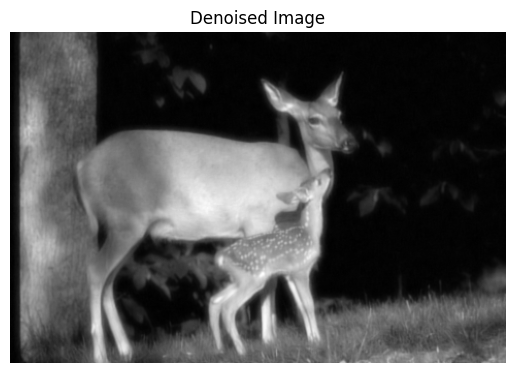

In [161]:
denoised_patches = np.array(denoised_patches) 
# Assemble the denoised patches into the final denoised image
# data = extract_patches_2d(im_gray, patch_size=(8,8))
# denoised_image = reconstruct_from_patches_2d(denoised_patches * np.std(data, axis=0), im_gray.shape)
denoised_image = reconstruct_from_patches_2d(denoised_patches, im_gray.shape)
# Display the denoised image
plt.imshow(denoised_image, cmap='gray')
plt.title('Denoised Image')
plt.axis('off')
plt.show()

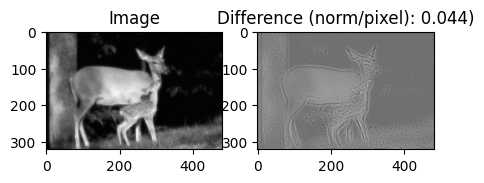

In [162]:
denoised_image = normalize_image(denoised_image)
im_gray = normalize_image(im_gray)
show_with_diff(denoised_image, im_gray)